
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

Cell 1: This is a team work produced by Xiaoping Wu and Likun Cao.

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

Cell 2:

# ***What?*** 
<200 words

Cell 3:The key purpose of the project is to answer the question of how different social classes are shaped in popular culture. We are going to look into the lines of characters from soap operas in the U.S., and see how the modes of language, habits, or behaviors vary across different social classes. Different social norms are expected to be related to wealth, power, and reputation. We also plan to dig out the mode of interaction between social classes, for example, whether the wording choice differs when a high-status character is talking to someone less privileged from the other way round. 

## ***Why?***
<200 words

Cell 4:Studying differences across classes has both theoretical and practical significance. We choose to place the context in the U.S., one of the countries with the widest gap of wealth in the world. However, there has been limited academic research into social classes from the perspective of language habits due to the lack of large-scale observational data.
The soap opera corpora could help us to fill the gap. T.V. shows reflect different social norms across classes. On the other hand, as a part of the popular culture, they shape or reinforce people’s understanding of the real world and potentially enhance and reproduce the inequality. Content analysis provides us with an excellent chance to study the culture of different social classes, and make further inferences about the cultural pattern related to stratification in the U.S.

## ***How?***
<400 words

Cell 5:We propose to use several methods to look into social classes, basing on the knowledge from this course. 
1)     Classification. Based on the lines of characters and other information, we can figure out whether a character is from a higher social class or a lower one. For the first step, we try to develop a classifier to identify a person’s social status from his words.
 
2)     Word frequency analysis. It would be interesting to see what the preferred words and collocations are by each social class. For example, it is expected that the upper social class uses more formal expressions, while lower social class uses vulgar words.
 
3)     Distributional distances analysis. The distance indicators are perfect tools for us to quantify the distance between social classes in various scenarios. By calculating the divergence indices, we can see how the distance varies under different social contexts. For example, the social class difference is likely to be larger in a show about adult daily life than in a show of school life. 
 
4)     Network analysis. By forming the social networks of characters, it would also be interesting to see how people interact within and across social classes. For example, people are expected to interact more closely with others from the same social group.
 
5)     Topic modeling. Topic modeling is the perfect tool for us to capture the patterns shared within social classes. It is expected that the lines by different social groups load differently on topics. For example, rich characters might pay more attention to financial markets and governmental decisions, while the poor ones might be more focused on daily necessities. It is also informative to further cluster the characters to see whether sub-classes are emerging in the operas and the features of these sub-classes.

Since we have not begun our analysis, we are not sure which method would produce the most exciting results. Other methods, such as word embedding and image analysis might also be involved, depending on our analytical needs.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).



## ***Which (words)?***
<300 words

Cell 6:In this project, we propose to use scripts of 10 soap operas to see how rich people and poor people are depicted in the cultural product in the U.S., and whether they have any difference in their behavior. If we take every episode as an independent sample, then we have more than 20,000 samples in total, which provide a solid basis for statistical analysis.  Although this is not a representative sample of all the soap operas in the U.S., it does reveal some cultural patterns of interest. Since all the ten soap operas have many episodes, we can also get information from the longitudinal development of the storyline.
We propose to use three dimensions of class status in classical sociology (drawn from Weber's theory): power, wealth, and reputation.  We propose to get each character's score on these three dimensions using word embeddings and examine the relationship between these measures and their social behavior, social network, and sentiment. Since these three dimensions do not overlap with each other, different kinds of characters may be found by clustering (for example, rich asians without power, powerful politicians without reputation).  Further analysis of these stereotypical characteristics will help us to understand how Americans see the social world, and how do they understand the rule of social games. 
The limitation of this study are as follows: (1) We only have a small dataset, so the result may not be generalized; (2) Soap opera is only one genre of cultural products and only reflect one aspect of the social game. 
However, since soap operas are based on the human experience of daily life, we still believe it provides the closest approximation to ordinary people's worldviews. 

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [4]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [5]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [6]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [7]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

We can also lookup the indices of different words using the Vectorizer

In [8]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [9]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [10]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [11]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [12]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
5       What is the value of an SE (HDFD) 4/20?\n\n-David
6       \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7       \n\n\n    Nope. The Apple 16" monitor does not...
8       \n\nIs it a hidden option?  I'm using PowerStr...
9       \n\n\nThe previous article referred to the fac...
10      \n\n\n    Yes. That is exactly what it means. ...
11      I saw once an article about a new line of Macs...
12      So, will it be possible to have a NuBus or PDS...
13      \n\n\nWho knows... I just quoted what was "wri...
14      \n\nI also returned PB memory last summer for ...
15      \n\nI think all Powerbooks use the same 2 Meg ...
16      A question in general about displaying NTSC th...
17      The li

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [13]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [14]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [15]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [16]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [17]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', '

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [18]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1


We can also look at the distinguishing features in each cluster:

In [19]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 sale
 00
 offer
 shipping
 condition
 asking
 new
 sell
 interested
 price


Cluster 1:
 know
 mac
 thanks
 just
 does
 drive
 apple
 like
 don
 problem


Cluster 2:
 window
 server
 motif
 use
 widget
 program
 application
 using
 like
 code


Cluster 3:
 car
 cars
 engine
 like
 just
 good
 think
 new
 don
 dealer




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [20]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [21]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [22]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

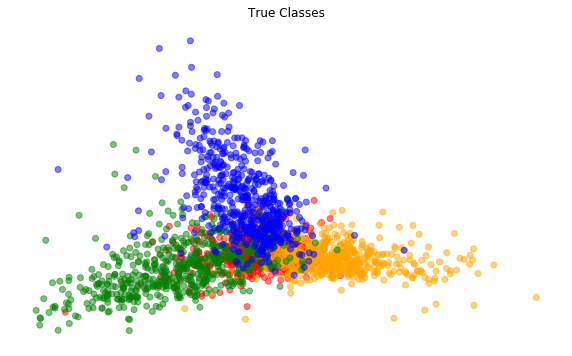

In [23]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

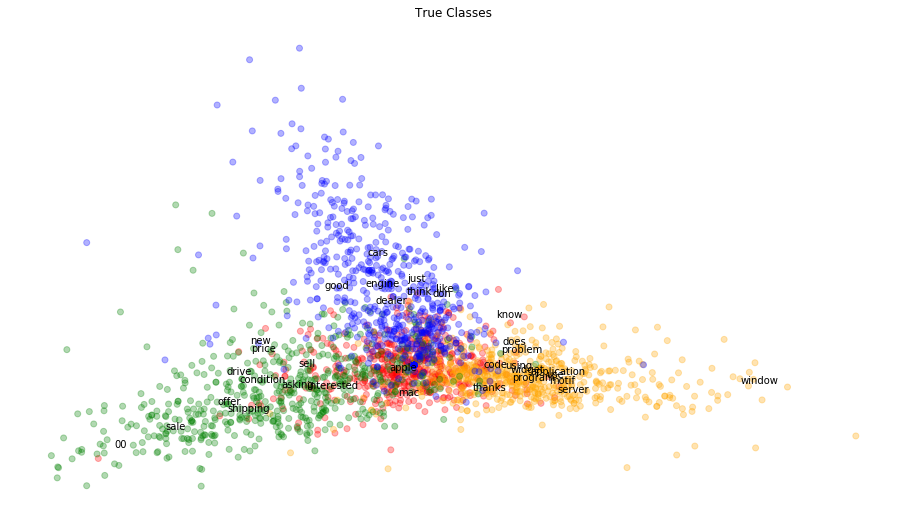

In [24]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [25]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

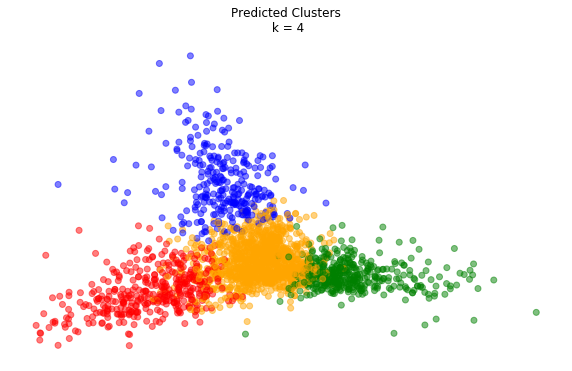

In [26]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [27]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [28]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


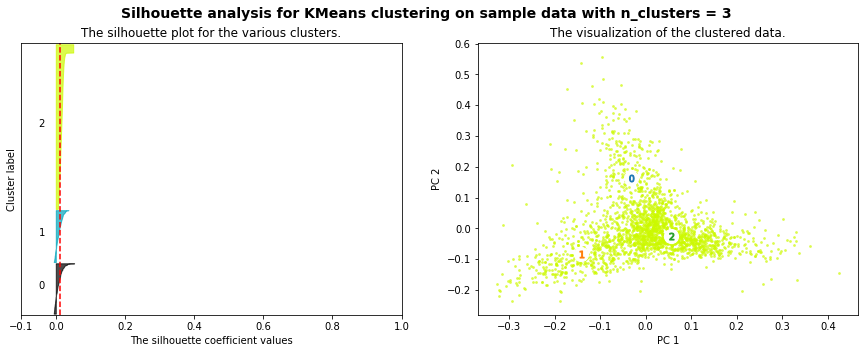

For n_clusters = 3, The average silhouette_score is : 0.013


In [29]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


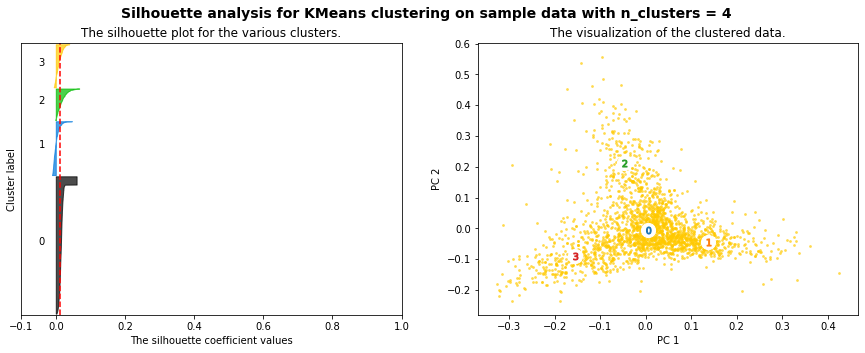

For n_clusters = 4, The average silhouette_score is : 0.012


In [30]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


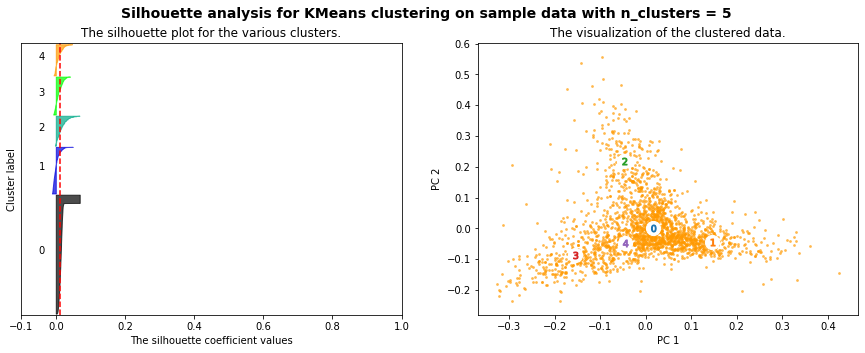

For n_clusters = 5, The average silhouette_score is : 0.011


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


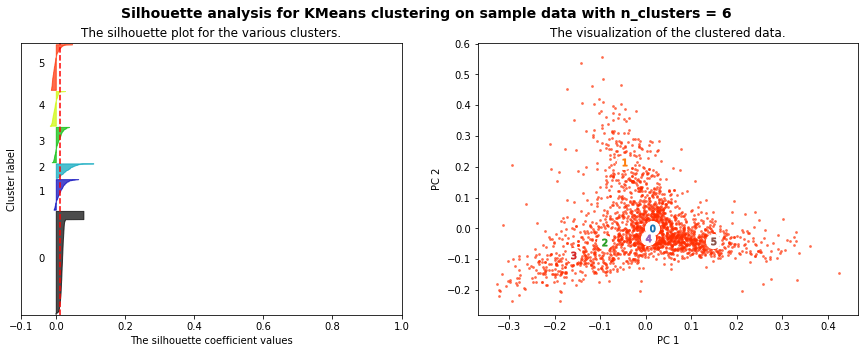

For n_clusters = 6, The average silhouette_score is : 0.011


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [ ]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']

#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud_2020.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("../data/senReleasesTraining.csv")

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [36]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [37]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [38]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [39]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [40]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

And visualize:

In [41]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

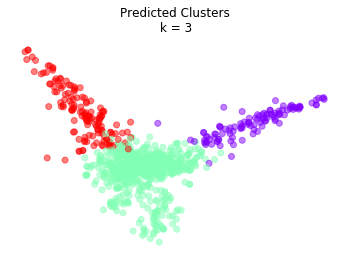

In [42]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [51]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,name,text,path,html_url,download_url,targetSenator,kmeans_predictions
0,0,01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Apr2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2
1,1,01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Aug2005Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1
2,2,01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy10.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2
3,3,01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy11.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1
4,4,01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy12.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1
5,5,01Aug2006Kennedy13.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy13.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1
6,6,01Aug2006Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/01Aug2006Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1
7,7,01Aug2007Kennedy5.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,raw/Kennedy/01Aug2007Kennedy5.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1
8,8,01Aug2007Kennedy6.txt,FOR IMMEDIATE RELEASE Rachel Racus...,raw/Kennedy/01Aug2007Kennedy6.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2
9,9,01Aug2007Kennedy7.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,raw/Kennedy/01Aug2007Kennedy7.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [2]:
#in this exercise we use the built-in function plotSilhouette. First we load the function.
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

We first load the corpus.In this exercise, I use business description of start-ups from 3 different industries (mining, wholesale and retail), and in total we have about 4000 samples.
The dimentions of document-word matrix is (4454, 21081)
If we use tf-idf vectorizer, the dimensions of document-word matrix is (4454, 2000)
 
The cluster with real categories are shown below.


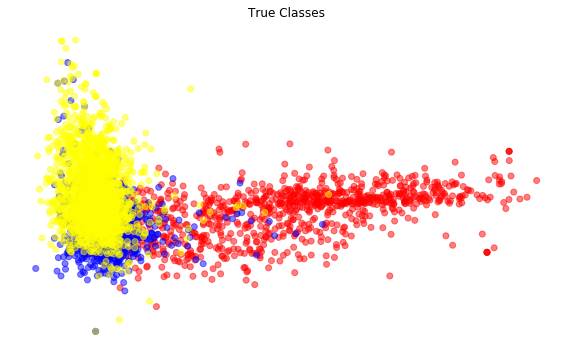

 
 
Now we build k-means clusters based on the tf-idf vectors.
1, 3-cluster.
For this clusters:
Homogeneity: 0.325
Completeness: 0.404
V-measure: 0.361
Adjusted Rand Score: 0.214
 
2, 4-cluster.
For this clusters:
Homogeneity: 0.334
Completeness: 0.359
V-measure: 0.346
Adjusted Rand Score: 0.185
 
3, 5-cluster.
For this clusters:
Homogeneity: 0.334
Completeness: 0.278
V-measure: 0.303
Adjusted Rand Score: 0.186
 
 
The predicted clusters of 3-cluster,4-cluster and 5-cluster are shown below.


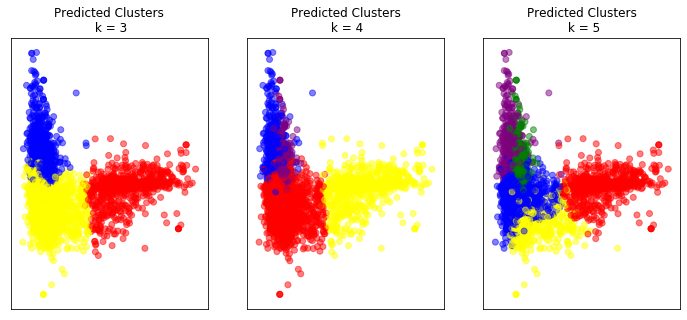

 
 
From the picture and measurements, we may come to the conclude that 3 or 4-cluster is the best number for clustering.


In [3]:
print("We first load the corpus.In this exercise, I use business description of start-ups from 3 different industries (mining, wholesale and retail), and in total we have about 4000 samples.")
busDF = pandas.read_csv('../data/classifier.csv')  #load the corpus
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
busVects = ngCountVectorizer.fit_transform(busDF['text'])
print("The dimentions of document-word matrix is "+str(busVects.shape))
busTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=2000, min_df=3, stop_words='english', norm='l2')
busTFVects = busTFVectorizer.fit_transform(busDF['text'])
print("If we use tf-idf vectorizer, the dimensions of document-word matrix is "+str(busTFVects.shape))
print(" ")
print("The cluster with real categories are shown below.")
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(busTFVects.toarray())
reduced_data = pca.transform(busTFVects.toarray())
colordict = {'mining': 'red','wholesale': 'blue','retail': 'yellow'}
colors = [colordict[c] for c in busDF['category']]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()
print(" ")
print(" ")
print("Now we build k-means clusters based on the tf-idf vectors.")
print("1, 3-cluster.")
numClusters=3
km3 = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km3.fit(busTFVects)
print("For this clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(busDF['category'], km3.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(busDF['category'], km3.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(busDF['category'], km3.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(busDF['category'], km3.labels_)))
print(" ")
print("2, 4-cluster.")
numClusters=4
km4 = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km4.fit(busTFVects)
print("For this clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(busDF['category'], km4.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(busDF['category'], km4.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(busDF['category'], km4.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(busDF['category'], km4.labels_)))
print(" ")
print("3, 5-cluster.")
numClusters=5
km5 = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km5.fit(busTFVects)
print("For this clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(busDF['category'], km5.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(busDF['category'], km5.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(busDF['category'], km5.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(busDF['category'], km5.labels_)))
print(" ")
print(" ")
print("The predicted clusters of 3-cluster,4-cluster and 5-cluster are shown below.")
colormap0=['red','blue','yellow','purple','green']
fig = plt.figure(figsize = (12,5))
colors_p = [colormap0[l] for l in km3.labels_]
plt.subplot(131)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')

colors_p = [colormap0[l] for l in km4.labels_]
ax = fig.add_subplot(132)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')

colors_p = [colormap0[l] for l in km5.labels_]
ax = fig.add_subplot(133)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color=colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 5')
plt.show()
print(" ")
print(" ")
print("From the picture and measurements, we may come to the conclude that 3 or 4-cluster is the best number for clustering.")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


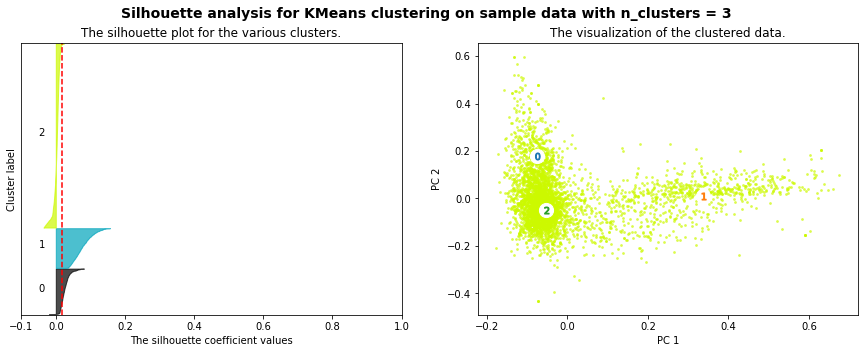

For n_clusters = 3, The average silhouette_score is : 0.017


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


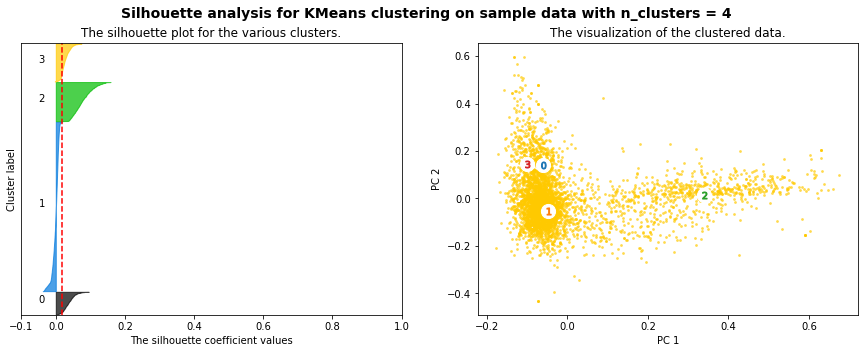

For n_clusters = 4, The average silhouette_score is : 0.018


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


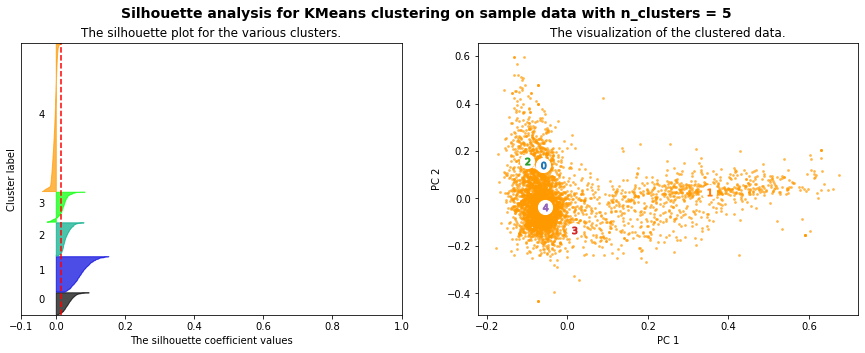

For n_clusters = 5, The average silhouette_score is : 0.016
 
The Sihouette analysis also reveals that 4 is the optimal cluster number for our corpus, in consistent with the conclusion we draw above. Although we have company descriptions from 3 industries, we there maybe a major division between 2 groups of companies from the same industry that we can reasonably put them into 2 different categories.


In [4]:
X = busTFVects.toarray()
plotSilhouette(3, X)
plotSilhouette(4, X)
plotSilhouette(5, X)
print(" ")
print("The Sihouette analysis also reveals that 4 is the optimal cluster number for our corpus, in consistent with the conclusion we draw above. Although we have company descriptions from 3 industries, we there maybe a major division between 2 groups of companies from the same industry that we can reasonably put them into 2 different categories.")

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [52]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [53]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [54]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


E:\software\Anaconda\lib\site-packages\scipy\sparse\compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [56]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [57]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [59]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

array([[ 26.        ,  93.        ,   0.        ,   2.        ],
       [ 95.        , 200.        ,   0.        ,   3.        ],
       [ 98.        , 201.        ,   0.        ,   4.        ],
       [105.        , 202.        ,   0.37033177,   5.        ],
       [  4.        ,  69.        ,   0.40914841,   2.        ],
       [110.        , 144.        ,   0.44134524,   2.        ],
       [ 62.        , 149.        ,   0.45096656,   2.        ],
       [ 51.        , 204.        ,   0.4553535 ,   3.        ],
       [ 17.        , 206.        ,   0.4650683 ,   3.        ],
       [102.        , 146.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

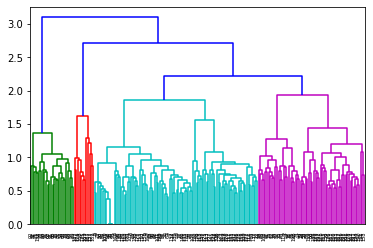

In [60]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

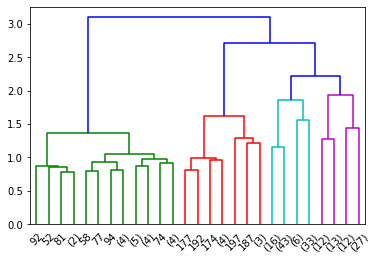

In [61]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [64]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4,
       3, 4, 4, 4, 3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4,
       4, 4, 4, 3, 3, 4, 4, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1,
       1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3,
       4, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 1, 4,
       4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 3, 2, 2, 2,
       4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4, 4, 4, 4, 2,
       4, 3], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [65]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [66]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,kmeans_predictions,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1,4
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1,4
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1,4
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1,4
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1,3
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data\20news_home\20news-b...,1,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [67]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

E:\software\Anaconda\lib\site-packages\scipy\sparse\compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values
E:\software\Anaconda\lib\site-packages\scipy\cluster\hierarchy.py:878: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

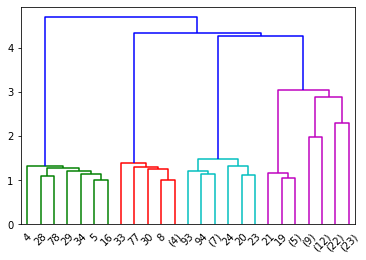

In [68]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [69]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 


<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

E:\software\Anaconda\lib\site-packages\scipy\sparse\compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


Firstly, we perform ward's clustering
For ward's clusters:
Homogeneity: 0.380
Completeness: 0.411
V-measure: 0.395
Adjusted Rand Score: 0.250
 
 


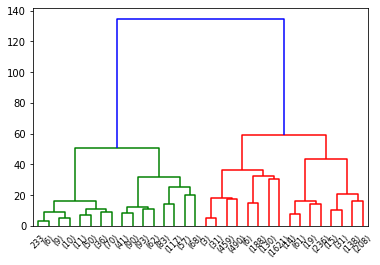

In [14]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import average, fcluster
busDF = pandas.read_csv('../data/classifier.csv')  #load the corpus
busTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=2000, min_df=3, stop_words='english', norm='l2')
busTFVects = busTFVectorizer.fit_transform(busDF['text'])
busCoocMat = busTFVects * busTFVects.T
busCoocMat.setdiag(0)
busCoocMat= pdist(busCoocMat.toarray())
print("Firstly, we perform ward's clustering")
linkage_matrix = scipy.cluster.hierarchy.ward(busCoocMat)
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
print("For ward's clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(busDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(busDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(busDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(busDF['category'], hierarchicalClusters_full)))
print(" ")
print(" ")

Secondly, we perform average clustering
For ward's clusters:
Homogeneity: 0.197
Completeness: 0.545
V-measure: 0.289
Adjusted Rand Score: 0.180


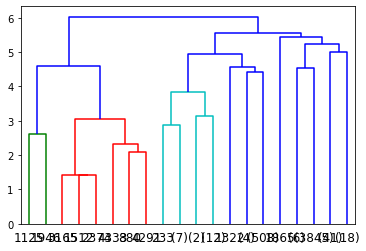

In [15]:
print("Secondly, we perform average clustering")
linkage_matrix_ave = scipy.cluster.hierarchy.average(busCoocMat)
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix_ave, p=4, truncate_mode='level', get_leaves=True)
hierarchicalClusters_full_ave = scipy.cluster.hierarchy.fcluster(linkage_matrix_ave, 4, 'maxclust')
print("For ward's clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(busDF['category'], hierarchicalClusters_full_ave)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(busDF['category'], hierarchicalClusters_full_ave)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(busDF['category'], hierarchicalClusters_full_ave)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(busDF['category'], hierarchicalClusters_full_ave)))

In [16]:
print("From the trees above, we can see that there are approximately 4 clusters in our corpus: our conclusion about optimal number of clusters in the exercise 1  makes sense. It is obvious that ward's clustering in this analysis have better performance than k-means clustering: it has higher homogeneity, completeness, V-measure and adjusted Rand Score. Although average linking clustering does not perform so well, it has higher completeness than other methods. The reason may be that data point is relatively sparse in our sementic space, so K-means cluster might have quite different results if the starting point is assigned randomly. Hierarchial clustering, on the other hand, depends solely on the content of the text and their distance, and produce more robust results.")

From the trees above, we can see that there are approximately 4 clusters in our corpus: our conclusion about optimal number of clusters in the exercise 1  makes sense. It is obvious that ward's clustering in this analysis have better performance than k-means clustering: it has higher homogeneity, completeness, V-measure and adjusted Rand Score. Although average linking clustering does not perform so well, it has higher completeness than other methods. The reason may be that data point is relatively sparse in our sementic space, so K-means cluster might have quite different results if the starting point is assigned randomly. Hierarchial clustering, on the other hand, depends solely on the content of the text and their distance, and produce more robust results.


E:\software\Anaconda\lib\site-packages\scipy\sparse\compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


Next, we change the distance. In the analysis above, we use the default euclidean. Now we try squeclidean distance, defined as the squared Euclidean distance.We still use ward's clustering.
For ward's cluster with sqeuclidean distance:
Homogeneity: 0.348
Completeness: 0.389
V-measure: 0.367
Adjusted Rand Score: 0.210
It can be seen that this method has similar clustering result to ward with euclidean, but the measures are different.


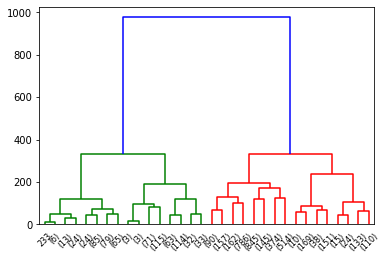

In [18]:
busCoocMat = busTFVects * busTFVects.T
busCoocMat.setdiag(0)
busCoocMat= pdist(busCoocMat.toarray(),'sqeuclidean')
linkage_matrix = scipy.cluster.hierarchy.ward(busCoocMat)
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
print("Next, we change the distance. In the analysis above, we use the default euclidean. Now we try squeclidean distance, defined as the squared Euclidean distance.We still use ward's clustering.")
print("For ward's cluster with sqeuclidean distance:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(busDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(busDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(busDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(busDF['category'], hierarchicalClusters_full)))
print("It can be seen that this method has similar clustering result to ward with euclidean, but the measures are different.")

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [70]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [71]:
senReleasesTraining[::100]

,Unnamed: 0,name,text,path,html_url,download_url,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,raw/Kennedy/01Apr2005Kennedy14.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
101,101,02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,raw/Kennedy/02Feb2006Kennedy8.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
201,201,04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,raw/Kennedy/04May2006Kennedy7.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
301,301,06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/06Jun2006Kennedy5.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
401,401,08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,raw/Kennedy/08Dec2006Kennedy4.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
501,501,09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,raw/Kennedy/09Nov2005Kennedy10.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
601,601,11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,raw/Kennedy/11Nov2005Kennedy5.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
701,701,13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,raw/Kennedy/13Jun2006Kennedy0.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
801,801,15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,raw/Kennedy/15Dec2005Kennedy4.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
901,901,16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,raw/Kennedy/16May2007Kennedy10.txt,https://github.com/lintool/GrimmerSenatePressR...,https://raw.githubusercontent.com/lintool/Grim...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [72]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [73]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [74]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [82]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [84]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [85]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(2, 0.97404057)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [87]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [89]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(0, 0.44315493), (1, 0.53180677)]",0.443155,0.531807,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
102,02Feb2007Kennedy10.txt,"[(0, 0.80773324), (2, 0.10960364), (3, 0.07884...",0.807733,0.000000,0.109604,0.078849,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
202,04May2006Kennedy8.txt,"[(4, 0.9974865)]",0.000000,0.000000,0.000000,0.000000,0.997486,0.00000,0.000000,0.000000,0.000000,0.000000
302,06Jun2007Kennedy1.txt,"[(3, 0.038288668), (5, 0.25844046), (6, 0.1181...",0.000000,0.000000,0.000000,0.038289,0.000000,0.25844,0.118134,0.000000,0.000000,0.582841
402,08Feb2005Kennedy0.txt,"[(1, 0.32445526), (2, 0.6697898)]",0.000000,0.324455,0.669790,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
502,09Nov2005Kennedy11.txt,"[(6, 0.46388727), (8, 0.49679804)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.463887,0.000000,0.496798,0.000000
602,11Nov2005Kennedy6.txt,"[(6, 0.5882365), (7, 0.38739234)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.588237,0.387392,0.000000,0.000000
702,13Jun2006Kennedy1.txt,"[(1, 0.028028894), (2, 0.12242751), (8, 0.2102...",0.000000,0.028029,0.122428,0.000000,0.000000,0.00000,0.000000,0.000000,0.210236,0.637342
802,15Dec2005Kennedy5.txt,"[(1, 0.025774077), (2, 0.80503917), (5, 0.1678...",0.000000,0.025774,0.805039,0.000000,0.000000,0.16785,0.000000,0.000000,0.000000,0.000000
902,16May2007Kennedy5.txt,"[(2, 0.9547582)]",0.000000,0.000000,0.954758,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [90]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.000000,0.974039,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000
1,0.443155,0.531807,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000
2,0.000000,0.000000,0.038045,0.0,0.810893,0.14575,0.0,0.000000,0.0,0.000000
3,0.000000,0.000000,0.917436,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.076598
4,0.000000,0.000000,0.592200,0.0,0.405767,0.00000,0.0,0.000000,0.0,0.000000
5,0.000000,0.000000,0.000000,0.0,0.991360,0.00000,0.0,0.000000,0.0,0.000000
6,0.989640,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000
7,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.967505,0.0,0.000000
8,0.000000,0.000000,0.000000,0.0,0.994777,0.00000,0.0,0.000000,0.0,0.000000
9,0.000000,0.000000,0.000000,0.0,0.967373,0.00000,0.0,0.000000,0.0,0.000000


First we can visualize as a stacked bar chart:

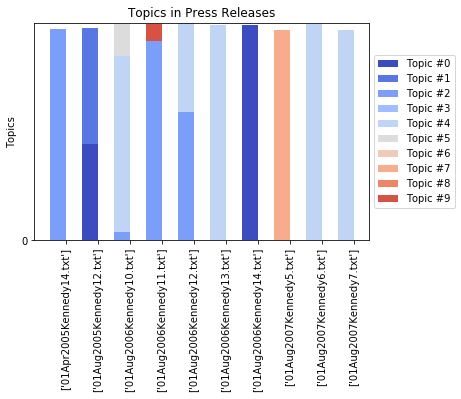

In [91]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

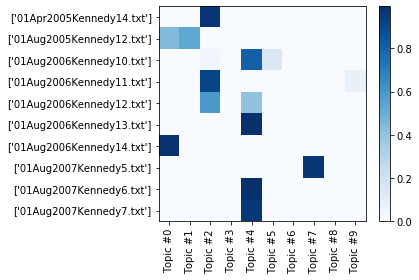

In [92]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [93]:
senlda.show_topic(1)

[('fund', 0.009016083),
 ('medicare', 0.005008651),
 ('head', 0.0045807855),
 ('unite', 0.0036774126),
 ('worker', 0.003427209),
 ('senior', 0.0032667273),
 ('hear', 0.0032115683),
 ('loan', 0.003116951),
 ('train', 0.0030239823),
 ('company', 0.0028792054)]

And if we want to make a dataFrame:

In [94]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,wage,fund,worker,fund,wage,fund,fund,fund,fund,immigration
1,worker,medicare,fund,troop,minimum,worker,worker,asbestos,asbestos,worker
2,minimum,head,pension,insurance,loan,head,immigrant,worker,loan,fund
3,loan,unite,company,coverage,worker,victim,loan,woman,victim,immigrant
4,judge,worker,science,question,lender,document,immigration,teacher,immigration,insurance
5,unite,senior,loan,medicare,fund,asbestos,employer,company,unite,unite
6,troop,hear,fda,worker,rate,wage,unite,troop,company,victim
7,leader,loan,retirement,individual,hour,loan,citizen,mental,trust,individual
8,fund,train,teacher,standard,woman,company,pension,fda,worker,follow
9,violence,company,bankruptcy,follow,cell,judge,company,victim,compensation,company


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

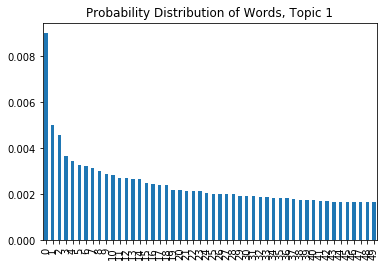

In [95]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [96]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

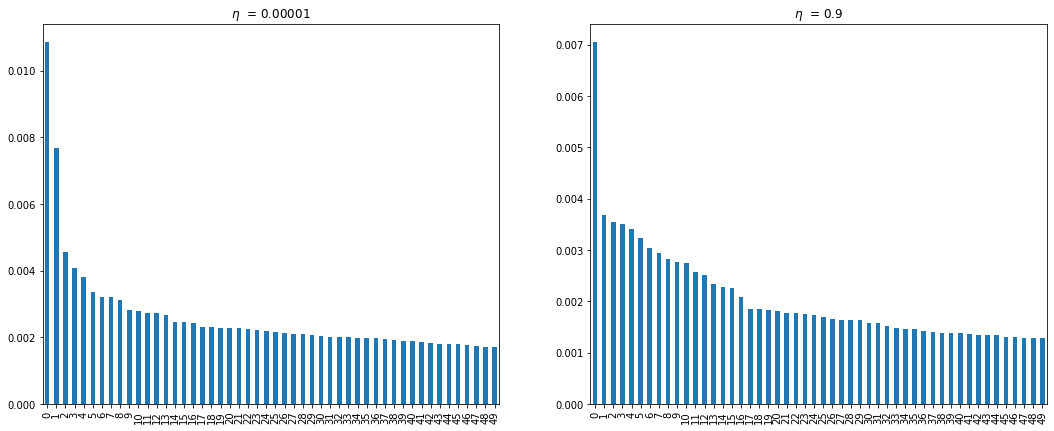

In [97]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [25]:
#In this analysis, we use the built-in function dropMissing.
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

In [27]:
busTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=2000, min_df=3, stop_words='english', norm='l2')
busTFVects = busTFVectorizer.fit_transform(busDF['text'])
busDF['tokenized_text'] = busDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
busDF['normalized_tokens'] = busDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
busDF['reduced_tokens'] = busDF['normalized_tokens'].apply(lambda x: dropMissing(x, busTFVectorizer.vocabulary_.keys()))
dictionary = gensim.corpora.Dictionary(busDF['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in busDF['reduced_tokens']]
gensim.corpora.MmCorpus.serialize('bus.mm', corpus)
bus = gensim.corpora.MmCorpus('bus.mm')
buslda = gensim.models.ldamodel.LdaModel(corpus=bus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')
ldaDF = pandas.DataFrame({
        'company id' : busDF['companyid'],
        'topics' : [buslda[dictionary.doc2bow(l)] for l in busDF['reduced_tokens']]})
topicsProbDict = {i : [0] * len(ldaDF) for i in range(buslda.num_topics)}
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob
for topicNum in range(buslda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
print('First we train the LDA model based on our business description corpus.The document-topic dataframe is listed as follows (a sample).')
ldaDF[1::500]

First we train the LDA model based on our business description corpus.The document-topic dataframe is listed as follows (a sample).


,company id,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,C000000241,"[(0, 0.014454076), (1, 0.010866214), (2, 0.015...",0.014454,0.010866,0.015495,0.645426,0.000000,0.000000,0.000000,0.012785,0.265155,0.010450
501,C903224597,"[(3, 0.8405509), (8, 0.14795467)]",0.000000,0.000000,0.000000,0.840551,0.000000,0.000000,0.000000,0.000000,0.147955,0.000000
1001,C000019158,"[(1, 0.67331517), (7, 0.29464507)]",0.000000,0.673315,0.000000,0.000000,0.000000,0.000000,0.000000,0.294645,0.000000,0.000000
1501,C901217579,"[(0, 0.029581375), (1, 0.022245739), (2, 0.031...",0.029581,0.022246,0.031730,0.015266,0.015868,0.238727,0.020085,0.026173,0.016302,0.584021
2001,C903353165,"[(0, 0.016570147), (1, 0.012458735), (2, 0.897...",0.016570,0.012459,0.897568,0.000000,0.000000,0.000000,0.011249,0.014655,0.000000,0.011982
2501,C000001343,"[(0, 0.023433993), (1, 0.017628461), (2, 0.855...",0.023434,0.017628,0.855077,0.012098,0.012575,0.012664,0.015917,0.020734,0.012919,0.016954
3001,C900539709,"[(0, 0.029574374), (1, 0.022243591), (2, 0.340...",0.029574,0.022244,0.340364,0.015266,0.015868,0.015980,0.020084,0.502927,0.016301,0.021393
3501,C901852240,"[(0, 0.17756043), (1, 0.36387008), (6, 0.12417...",0.177560,0.363870,0.000000,0.000000,0.000000,0.000000,0.124173,0.077169,0.000000,0.238895
4001,C903683305,"[(2, 0.1426652), (4, 0.3436452), (7, 0.48509786)]",0.000000,0.000000,0.142665,0.000000,0.343645,0.000000,0.000000,0.485098,0.000000,0.000000


Now we draw the picture of document-topic loading. We only show the topic loading of the first ten texts, as the example codes show.


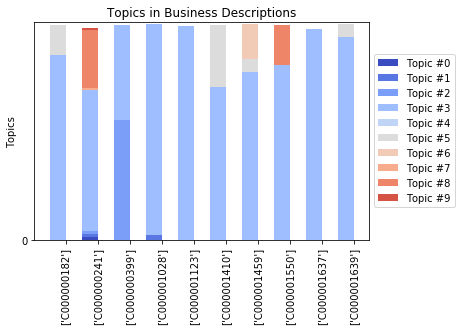

In [31]:
print('Now we draw the picture of document-topic loading. We only show the topic loading of the first ten texts, as the example codes show.')
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['company id']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
N = 10
ind = np.arange(N)
K = buslda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)
for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')
plt.title('Topics in Business Descriptions')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')
plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))
plt.show()

Next, we try to draw the picture of topic-word loading. We use topic 3 as an example since the first 10 texts have a very high proportion of topic 3.
We can see from this picture that the word loadings of topic 3 is very close to a power-law distribution.


<Figure size 432x288 with 0 Axes>

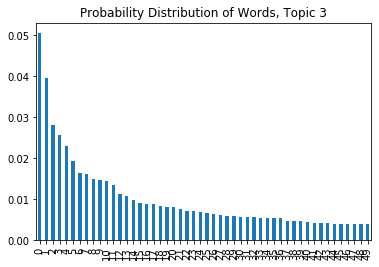

In [34]:
print("Next, we try to draw the picture of topic-word loading. We use topic 3 as an example since the first 10 texts have a very high proportion of topic 3.")
print("We can see from this picture that the word loadings of topic 3 is very close to a power-law distribution.")
topic3_df = pandas.DataFrame(buslda.show_topic(3, topn=50))
plt.figure()
topic3_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 3')
plt.show()

In [37]:
print("We can turn the keyword of each topic into a dataframe and try to figure out what each topic is about. The dataframe is as follows.")
topicsDict = {}
for topicNum in range(buslda.num_topics):
    topicWords = [w for w, p in buslda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords
buswordRanksDF = pandas.DataFrame(topicsDict)
print("Thus we can see topic_0 is mostly about the action of companies (offer, product, provide, service, etc), topic_1 is about food, topic_2 is about retail and stores, topic_3 is about mining (oil and gas), etc. The topics separate different contents accurately.")
buswordRanksDF

We can turn the keyword of each topic into a dataframe and try to figure out what each topic is about. The dataframe is as follows.
Thus we can see topic_0 is mostly about the action of companies (offer, product, provide, service, etc), topic_1 is about food, topic_2 is about retail and stores, topic_3 is about mining (oil and gas), etc. The topics separate different contents accurately.


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,include,state,operate,oil,pizza,include,salad,offer,state,product
1,offer,base,store,gas,sport,equipment,service,include,base,restaurant
2,product,restaurant,state,operate,wine,favorite,state,product,service,offer
3,state,meal,product,state,fashion,car,include,base,llc,food
4,base,operate,service,service,subscription,service,offer,state,send,include
5,accessory,food,include,italian,sell,provide,base,provide,product,base
6,category,include,base,base,swimwear,chocolate,operate,online,offer,state
7,chicken,product,offer,natural,footwear,base,food,gift,gas,operate
8,provide,llc,provide,texas,operate,state,provide,service,include,brand
9,service,breakfast,retail,exploration,state,necklace,jewelry,item,oil,drink


Next we change 𝛼, 𝜂, and topic number of the model.
For 𝛼, we use 2 values: 0.001 and 0.9.
For 𝜂, we use 2 values: 0.001 and 0.9.
For topic numbers, we use 2 values: 3 and 10.
Then we have 2*2*2=8 models in total.
Here is the topic-word loading (topic 1) for different α,η, and topic numbers.


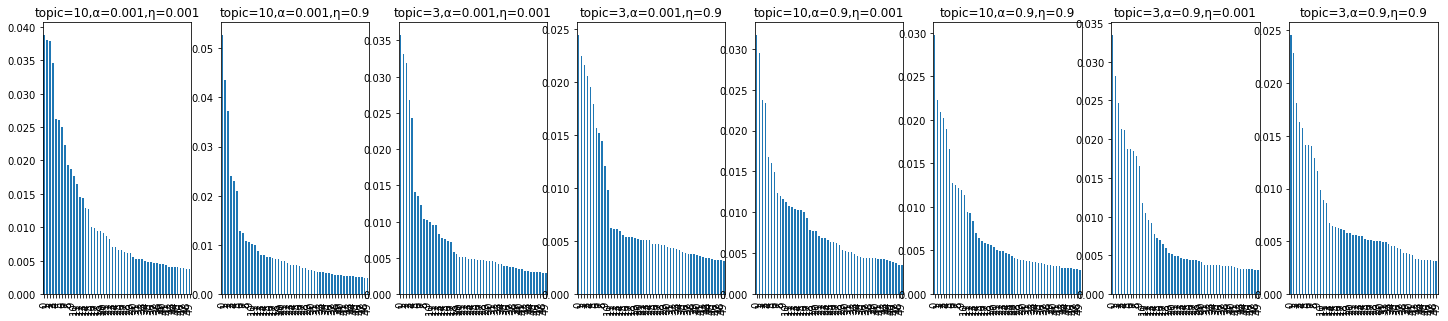

In [57]:
print("Next we change 𝛼, 𝜂, and topic number of the model.")
print("For 𝛼, we use 2 values: 0.001 and 0.9.")
print("For 𝜂, we use 2 values: 0.001 and 0.9.")
print("For topic numbers, we use 2 values: 3 and 10.")
print("Then we have 2*2*2=8 models in total.")

buslda1 = gensim.models.ldamodel.LdaModel(corpus=bus, id2word=dictionary, num_topics=10, alpha=0.001, eta=0.001)
buslda2 = gensim.models.ldamodel.LdaModel(corpus=bus, id2word=dictionary, num_topics=10, alpha=0.001, eta=0.9)
buslda3 = gensim.models.ldamodel.LdaModel(corpus=bus, id2word=dictionary, num_topics=3, alpha=0.001, eta=0.001)
buslda4 = gensim.models.ldamodel.LdaModel(corpus=bus, id2word=dictionary, num_topics=3, alpha=0.001, eta=0.9)
buslda5 = gensim.models.ldamodel.LdaModel(corpus=bus, id2word=dictionary, num_topics=10, alpha=0.9, eta=0.001)
buslda6 = gensim.models.ldamodel.LdaModel(corpus=bus, id2word=dictionary, num_topics=10, alpha=0.9, eta=0.9)
buslda7 = gensim.models.ldamodel.LdaModel(corpus=bus, id2word=dictionary, num_topics=3, alpha=0.9, eta=0.001)
buslda8 = gensim.models.ldamodel.LdaModel(corpus=bus, id2word=dictionary, num_topics=3, alpha=0.9, eta=0.9)
topic11_df = pandas.DataFrame(buslda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(buslda2.show_topic(1, topn=50))
topic31_df = pandas.DataFrame(buslda3.show_topic(1, topn=50))
topic41_df = pandas.DataFrame(buslda4.show_topic(1, topn=50))
topic51_df = pandas.DataFrame(buslda5.show_topic(1, topn=50))
topic61_df = pandas.DataFrame(buslda6.show_topic(1, topn=50))
topic71_df = pandas.DataFrame(buslda7.show_topic(1, topn=50))
topic81_df = pandas.DataFrame(buslda8.show_topic(1, topn=50))
print("Here is the topic-word loading (topic 1) for different α,η, and topic numbers.")
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(1,8)
fig.set_size_inches(25, 5)
topic11_df.plot.bar(legend = False, ax = ax1, title = 'topic=10,α=0.001,η=0.001')
topic21_df.plot.bar(legend = False, ax = ax2, title = 'topic=10,α=0.001,η=0.9')
topic31_df.plot.bar(legend = False, ax = ax3, title = 'topic=3,α=0.001,η=0.001')
topic41_df.plot.bar(legend = False, ax = ax4, title = 'topic=3,α=0.001,η=0.9')
topic51_df.plot.bar(legend = False, ax = ax5, title = 'topic=10,α=0.9,η=0.001')
topic61_df.plot.bar(legend = False, ax = ax6, title = 'topic=10,α=0.9,η=0.9')
topic71_df.plot.bar(legend = False, ax = ax7, title = 'topic=3,α=0.9,η=0.001')
topic81_df.plot.bar(legend = False, ax = ax8, title = 'topic=3,α=0.9,η=0.9')
plt.show()

In [58]:
print("In LDA model, topic numbers refer to the number of topics generated from our corpus,αexpresses the a-priori belief for each topic’s probability, and η expresses the a-priori belief on word probability.From the picture above we can see that when there are few topics and large α and η, the word distribution for a single topic has a higher variance (many words are in the same topic), and this is also true for the opposite case.")

In LDA model, topic numbers refer to the number of topics generated from our corpus,αexpresses the a-priori belief for each topic’s probability, and η expresses the a-priori belief on word probability.From the picture above we can see that when there are few topics and large α and η, the word distribution for a single topic has a higher variance (many words are in the same topic), and this is also true for the opposite case.


Finally, we feed topic loadings into clustering algorithm. We still use ward's clustering with euclidean distance.
For ward's clusters with topics as input:
Homogeneity: 0.283
Completeness: 0.243
V-measure: 0.261
Adjusted Rand Score: 0.166
From the measures, we can see that when puting the topics into the clustering algorithm, the homogeneity, completeness, etc. have decreased. This may be due to the topics have different scales with the original word loadings, so it distorts the distance between data points and negatively influence our model. Maybe re-scaling the topic loadings will improve the results. 


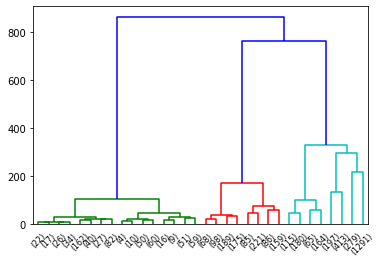

In [92]:
print("Finally, we feed topic loadings into clustering algorithm. We still use ward's clustering with euclidean distance.")
import numpy
from scipy import sparse
busTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=2000, min_df=3, stop_words='english', norm='l2')
busTFVects = busTFVectorizer.fit_transform(busDF['text'])
topicfeature=ldaDF.as_matrix(columns=['topic_0','topic_1','topic_2','topic_3','topic_4','topic_5','topic_6','topic_7','topic_8','topic_9'])
newbusVect=np.concatenate((busTFVects.toarray(),topicfeature),axis=1)
sparsebus = sparse.csr_matrix(newbusVect)
busCoocMatnew = sparsebus * sparsebus.T
busCoocMatnew.setdiag(0)
busCoocMatnew= pdist(busCoocMatnew.toarray())
linkage_matrix = scipy.cluster.hierarchy.ward(busCoocMatnew)
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
print("For ward's clusters with topics as input:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(busDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(busDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(busDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(busDF['category'], hierarchicalClusters_full)))
print("From the measures, we can see that when puting the topics into the clustering algorithm, the homogeneity, completeness, etc. have decreased. This may be due to the topics have different scales with the original word loadings, so it distorts the distance between data points and negatively influence our model. Maybe re-scaling the topic loadings will improve the results. ")

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [111]:
corpora_address = "../data/SOAP"

In [112]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_0-tez.zip
text_1-teh.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_5-rag.zip
text_6-egn.zip
text_7-jss.zip
text_8-sbo.zip
text_9-jtw.zip


In [113]:
import zipfile
import pandas as pd

In [114]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [115]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [116]:
soap_dict = {}

In [117]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [118]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [119]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [120]:
i = 0

In [121]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [122]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Liza, You, 're, in, early, @!Ryan, Yeah, I,..."
1,As the World Turns,"[@!Katie, Simon, where, are, you, @!Simon, Kat..."
2,Bold and Beautiful,"[@!Morgan, What, 's, the, matter, Stephanie, Y..."
3,Days of Our Lives,"[@!Philip, Seems, like, every, time, I, look, ..."
4,General Hospital,"[@!Stefan, I, love, her, @!Jax, No, Cassadine,..."
5,Guiding Light,"[@!Reva, Well, it, 's, very, peaceful, Your, b..."
6,One Life to Live,"[@!Rae, What, She, even, has, a, new, friend, ..."
7,Passions,"[@!Kay, Going, to, get, pregnant, and, I, 'm, ..."
8,Port Charles,"[@!Jack, There, you, are, you, son, @!Chris, H..."
9,Young and Restless,"[@!Sharon, Yeah, I, could, n't, sleep, @!Victo..."


Checking to see which index I should use. In my example it is the first one, so I choose my index as 0. It might be different for you!

In [155]:
dool = soap_df['Tokenized Texts'][1]

In [156]:
' '.join(dool[0:1500])

"@!Katie Simon where are you @!Simon Katie @!Katie You 're in my dream @!Simon No I 'm on your damn beach If you do anything like this again I 'm gon na leave you here Katie drops a coconut on Simon 's foot Ow @Ow ow @!Katie Oh Simon I 'm sorry I 'm so so sorry @!Simon Do n't do n't touch me @!Katie Is your foot okay @!Simon Yes it 's fine Leave me alone Ow @!Katie You found me @!Simon Yes yes I found you What do you think I 'm going to do just leave you here Wake up @!Jack Ca n't find record of payment Past due past due Past due past due Carly You 're up early Sorry Carly goes into the kitchen and brings out an empty coffee pot Hey Did you drink all this @!Jack Yeah Sorry @!Carly No no that 's it 's okay you might not sleep for a week Hey it 's going to be okay Jack We can always use the Carly Tenney system @!Jack Rob a bank @!Carly No that 's Plan B Plan A you just throw all the bills up in the air and whatever stays up there well that deserves to get paid @!Jack With what I gave her

In [157]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [158]:
import networkx as nx

In [159]:
actor_network = nx.Graph()

In [160]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [161]:
i = 0

In [162]:
all_texts = []

In [163]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

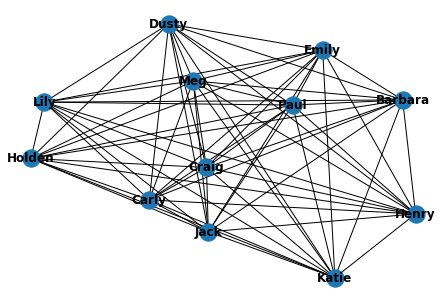

In [181]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [182]:
all_texts[0:10]

[['simon'],
 ['dream'],
 ['oh', 'simon', 'be', 'sorry', 'be', 'sorry'],
 ['foot', 'okay'],
 ['find'],
 ['find',
  'record',
  'payment',
  'past',
  'past',
  'past',
  'past',
  'carly',
  'early',
  'sorry',
  'carly',
  'go',
  'kitchen',
  'bring',
  'coffee',
  'pot',
  'hey',
  'drink'],
 ['yes', 'sorry'],
 ['okay',
  'sleep',
  'week',
  'hey',
  'go',
  'okay',
  'jack',
  'use',
  'carly',
  'tenney',
  'system'],
 ['rob', 'bank'],
 ['plan', 'b', 'plan', 'throw', 'bill', 'air', 'stay', 'deserve', 'pay']]

In [183]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [184]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [185]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [186]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [187]:
doollda.show_topics()

[(0,
  '0.075*"think" + 0.058*"mean" + 0.055*"love" + 0.036*"talk" + 0.031*"happen" + 0.024*"be" + 0.019*"great" + 0.017*"like" + 0.016*"know" + 0.016*"woman"'),
 (1,
  '0.131*"oh" + 0.073*"thank" + 0.068*"good" + 0.035*"hello" + 0.034*"damian" + 0.031*"holden" + 0.027*"god" + 0.026*"lily" + 0.018*"let" + 0.017*"luke"'),
 (2,
  '0.124*"okay" + 0.096*"na" + 0.095*"gon" + 0.064*"be" + 0.039*"sure" + 0.039*"paul" + 0.029*"home" + 0.021*"meg" + 0.020*"find" + 0.019*"go"'),
 (3,
  '0.061*"come" + 0.051*"get" + 0.032*"stop" + 0.030*"wait" + 0.028*"well" + 0.026*"think" + 0.025*"feel" + 0.024*"know" + 0.022*"maybe" + 0.019*"have"'),
 (4,
  '0.056*"help" + 0.047*"try" + 0.040*"fine" + 0.035*"parker" + 0.033*"craig" + 0.029*"jack" + 0.028*"be" + 0.024*"hear" + 0.019*"get" + 0.018*"course"'),
 (5,
  '0.166*"yes" + 0.119*"right" + 0.035*"say" + 0.035*"like" + 0.028*"know" + 0.020*"baby" + 0.020*"sigh" + 0.014*"business" + 0.013*"guess" + 0.013*"exactly"'),
 (6,
  '0.138*"want" + 0.033*"ask" + 0.0

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [205]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [206]:
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(0, 0.33157444), (1, 0.24832992), (3, 0.048004974), (4, 0.08168496), (5, 0.2903993)]
[(0, 0.3189464), (1, 0.24867982), (3, 0.045319095), (4, 0.08473583), (5, 0.3023134)]
[(0, 0.32660368), (1, 0.24734472), (3, 0.04734041), (4, 0.079973936), (5, 0.29873267)]
[(0, 0.3326239), (1, 0.24968044), (3, 0.04370604), (4, 0.08299357), (5, 0.29098713)]
[(0, 0.3249891), (1, 0.25434944), (3, 0.045958146), (4, 0.078834), (5, 0.29586336)]
[(0, 0.3211822), (1, 0.25785577), (3, 0.050712503), (4, 0.075963356), (5, 0.29427624)]
[(0, 0.32602507), (1, 0.2521733), (3, 0.043809894), (4, 0.08156231), (5, 0.2964239)]
[(0, 0.33187667), (1, 0.25491208), (3, 0.046238042), (4, 0.07613303), (5, 0.29083207)]
[(0, 0.3337384), (1, 0.24872868), (3, 0.043641612), (4, 0.07532749), (5, 0.29855582)]
[(0, 0.3245578), (1, 0.2432357), (3, 0.04323693), (4, 0.07990709), (5, 0.3090533)]
[(0, 0.3337514), (1, 0.24393426), (3, 0.040773146), (4, 0.08596148), (5, 0.2955686)]
[(0, 0.3331908), (1, 0.24405192), (3, 0.04505696), (4, 0.079

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [197]:
from gensim.matutils import kullback_leibler

In [198]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [207]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [208]:
for i in actor_network.nodes():
    print(actor_network.nodes[i]['topic_distribution'])

[(0, 0.33157444), (1, 0.24832992), (3, 0.048004974), (4, 0.08168496), (5, 0.2903993)]
[(0, 0.3189464), (1, 0.24867982), (3, 0.045319095), (4, 0.08473583), (5, 0.3023134)]
[(0, 0.32660368), (1, 0.24734472), (3, 0.04734041), (4, 0.079973936), (5, 0.29873267)]
[(0, 0.3326239), (1, 0.24968044), (3, 0.04370604), (4, 0.08299357), (5, 0.29098713)]
[(0, 0.3249891), (1, 0.25434944), (3, 0.045958146), (4, 0.078834), (5, 0.29586336)]
[(0, 0.3211822), (1, 0.25785577), (3, 0.050712503), (4, 0.075963356), (5, 0.29427624)]
[(0, 0.32602507), (1, 0.2521733), (3, 0.043809894), (4, 0.08156231), (5, 0.2964239)]
[(0, 0.33187667), (1, 0.25491208), (3, 0.046238042), (4, 0.07613303), (5, 0.29083207)]
[(0, 0.3337384), (1, 0.24872868), (3, 0.043641612), (4, 0.07532749), (5, 0.29855582)]
[(0, 0.3245578), (1, 0.2432357), (3, 0.04323693), (4, 0.07990709), (5, 0.3090533)]
[(0, 0.3337514), (1, 0.24393426), (3, 0.040773146), (4, 0.08596148), (5, 0.2955686)]
[(0, 0.3331908), (1, 0.24405192), (3, 0.04505696), (4, 0.079

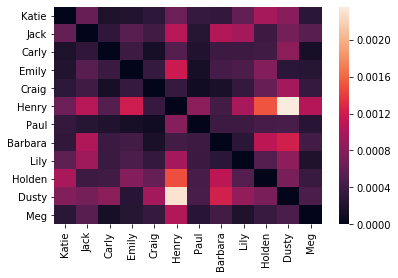

In [209]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [210]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [87]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


In [88]:
list(coha_texts.keys())[0:5]

['fic_2008_36162.txt',
 'news_1880_780902.txt',
 'mag_1949_182290.txt',
 'news_2005_629411.txt',
 'mag_1924_151906.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [89]:
coha_genres = {}
coha_years = {}

In [90]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [91]:
coha_genres.keys()

dict_keys(['nf', 'fic', 'news', 'mag'])

In [92]:
coha_years.keys()

dict_keys(['1985', '1903', '1864', '1845', '1922', '1957', '1869', '1961', '1982', '2004', '1814', '1995', '1949', '1923', '1856', '1947', '1867', '1857', '1842', '1915', '1945', '2009', '1929', '1926', '1879', '2000', '1948', '1994', '1837', '1918', '1895', '1976', '1861', '2002', '1816', '1970', '1847', '1874', '1939', '1848', '1997', '1811', '1852', '1819', '1877', '1914', '1932', '1911', '1850', '1986', '1944', '1937', '1833', '1822', '1917', '1984', '1840', '1952', '1849', '1843', '1875', '1888', '1868', '1975', '1892', '1851', '1991', '1934', '1897', '1902', '1925', '1955', '1828', '1829', '1871', '1953', '1956', '1873', '1977', '1910', '1826', '1971', '1904', '1967', '1951', '1924', '1920', '1989', '1824', '1954', '1835', '1965', '1844', '1913', '1884', '1988', '1890', '1990', '1933', '1996', '1972', '1865', '1896', '1846', '1838', '1942', '1968', '1941', '1818', '1858', '1827', '1836', '1872', '1943', '1928', '1876', '1960', '1832', '2005', '1962', '1841', '1936', '1919', '1969

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [93]:
import collections

In [94]:
years = []
year_lens = []

In [95]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [96]:
years[0], years[-1]

('1810', '2009')

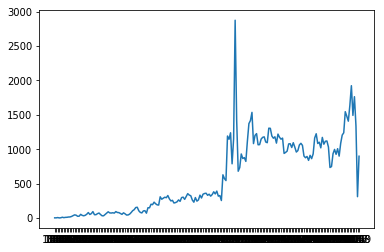

In [97]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: their are far less articles in the beginning, and then it grows. Maybe in our 4 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [126]:
all_texts_coha = []
docs_per_year = [0, 0, 0, 0, 0]
i = 0

In [127]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
            
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size.

In [138]:
def choose_n(corpus, time_slices, nums=1000):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

In [139]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [141]:
dictionary = gensim.corpora.Dictionary(small_corpus)

In [142]:
corpus = [dictionary.doc2bow(text) for text in small_corpus]

In [143]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [144]:
small_docs = [100, 100, 100, 100, 100]

In [134]:
from gensim.models import ldaseqmodel

In [135]:
# ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_year, num_topics=4)

In [147]:
 ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=small_docs, num_topics=4)

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [160]:
ldaseq.print_topics(time=0)[0]

[('man', 0.007132699478346652),
 ('country', 0.004953905335421504),
 ('river', 0.004601016260755985),
 ('come', 0.004500291109021736),
 ('day', 0.0044210075957709935),
 ('time', 0.004133759487293093),
 ('mile', 0.003944137336605276),
 ('find', 0.0039414990087118275),
 ('new', 0.0037711261892743137),
 ('take', 0.0033423523807046478),
 ('place', 0.0033304077024018395),
 ('water', 0.0032852971109775023),
 ('see', 0.0032341722380378798),
 ('horse', 0.003111974959331941),
 ('great', 0.003048816911899102),
 ('captain', 0.002908852096901459),
 ('general', 0.0028690081816825225),
 ('long', 0.002765556386804236),
 ('good', 0.002738278810545999),
 ('leave', 0.0026362890611356504)]

In [161]:
ldaseq.print_topics(time=4)[0]

[('man', 0.008601723705163314),
 ('<', 0.007390083882002291),
 ('come', 0.004732779554721947),
 ('time', 0.004674340167782232),
 ('p', 0.004658272137546079),
 ('day', 0.004440920798263172),
 ('country', 0.004434527009866553),
 ('>', 0.0042715116132568684),
 ('new', 0.00423322281132545),
 ('find', 0.0037647687876274046),
 ('river', 0.0037436664814792854),
 ('go', 0.0035399899048840144),
 ('take', 0.0033760965399826826),
 ('place', 0.0033265438797066144),
 ('see', 0.003210924518629936),
 ('mile', 0.0031607174358631368),
 ('year', 0.003150383583558314),
 ('horse', 0.0029602366528247745),
 ('long', 0.0029182123328693986),
 ('great', 0.0028928820979905005)]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [130]:
#In this analysis, we use the built-in function choose-n.
def choose_n(corpus, time_slices, nums=1000):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

In [138]:
busDF = pandas.read_csv('../data/classifier.csv')  #load the corpus
busDFws=busDF[busDF['category']=='mining']
busDFws['year'].fillna(1984,inplace=True) #we impute the missing value in 'year' with 1984 because this is the mean of the non-missing values.
all_texts = []
docs_per_year = [0, 0, 0]
for year in sorted(set(list(busDFws['year']))):
    textsforthisyear=0
    for article in busDFws[busDFws['year']==year]['text']:
        try:
            all_texts.append([i for i in lucem_illud_2020.normalizeTokens(article)])
            textsforthisyear+=1
        except IndexError:
            continue


    if year < 1980:
        docs_per_year[0] += len(busDFws[busDFws['year']==year])
    if year >= 1980 and year < 2000:
        docs_per_year[1] += len(busDFws[busDFws['year']==year])
    if year>2000:
        docs_per_year[2] += len(busDFws[busDFws['year']==year])
docs_per_year[1]=docs_per_year[0]+docs_per_year[1]
docs_per_year[2]=docs_per_year[1]+docs_per_year[2]
small_corpus = choose_n(all_texts, docs_per_year, nums=100)
dictionary = gensim.corpora.Dictionary(small_corpus)
corpus = [dictionary.doc2bow(text) for text in small_corpus]
gensim.corpora.MmCorpus.serialize('busdyn.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('busdyn.mm')
small_docs = [100, 100, 100]
from gensim.models import ldaseqmodel
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=small_docs, num_topics=4)
topicsDict = {}
for topic in range(0,4):
    for time in range(0,3):
        topicWords = [w for w,p in ldaseq.print_topics(time=time)[topic][0:20]]
        topicsDict['Topic_{} at time {}'.format(topic,time)] = topicWords
busdynDF = pandas.DataFrame(topicsDict)
print("In this section, we use a variable 'year', which is the establishing year of the company, to build a dynamic topic models.")
print("We cut the years into 3 time slices: before 1980, 1980-2000 and after 2000.")
print("To make it more conherent, we only use the descriptions of companies from the mining industry (n=951).")
print("We assume that there are 4 topics.")
print("After building the dynamic topic model, we can extract the keywords of 4 topics from each time point.")
busdynDF

E:\software\Anaconda\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
E:\software\Anaconda\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In this section, we use a variable 'year', which is the establishing year of the company, to build a dynamic topic models.
We cut the years into 3 time slices: before 1980, 1980-2000 and after 2000.
To make it more conherent, we only use the descriptions of companies from the mining industry (n=951).
We assume that there are 4 topics.
After building the dynamic topic model, we can extract the keywords of 4 topics from each time point.


,Topic_0 at time 0,Topic_0 at time 1,Topic_0 at time 2,Topic_1 at time 0,Topic_1 at time 1,Topic_1 at time 2,Topic_2 at time 0,Topic_2 at time 1,Topic_2 at time 2,Topic_3 at time 0,Topic_3 at time 1,Topic_3 at time 2
0,company,company,company,oil,gas,gas,service,service,service,company,company,company
1,coal,coal,coal,gas,oil,oil,company,company,company,seismic,seismic,seismic
2,gas,gas,gas,company,company,company,provide,provide,provide,oil,oil,oil
3,mine,mine,mine,exploration,exploration,exploration,drill,drill,drill,exploration,exploration,exploration
4,operate,operate,operate,operate,operate,operate,include,include,include,inc,inc,inc
5,natural,natural,natural,texas,texas,texas,gas,gas,gas,project,project,project
6,locate,locate,energy,natural,natural,natural,oil,oil,oil,operate,operate,operate
7,energy,energy,locate,production,production,production,state,state,state,include,manufacture,water
8,inc,inc,inc,development,development,development,product,product,product,manufacture,include,include
9,process,process,process,basin,basin,basin,unite,unite,unite,water,water,manufacture


In [141]:
print("From the results above, we may conclude that the business topics of companies from the mining industry are extremely stable: not only the same topic does not change much across time, but also different topics are quite similar.")
print(" ")
print("It is worth noting that difference does exist, especially for the unimportant words with lower loadings in the topic. However, change is rare in our example.The possible reason may be that we only use 300 descriptions (100 from each time period), and only the information of quite homogeneous companies (from the same indstry), so the semantic space is quite narrow. In the future, when we use more complex corpus, we may trace more changes of topics across time.")

From the results above, we may conclude that the business topics of companies from the mining industry are extremely stable: not only the same topic does not change much across time, but also different topics are quite similar.
 
It is worth noting that difference does exist, especially for the unimportant words with lower loadings in the topic. However, change is rare in our example.The possible reason may be that we only use 300 descriptions (100 from each time period), and only the information of quite homogeneous companies (from the same indstry), so the semantic space is quite narrow. In the future, when we use more complex corpus, we may trace more changes of topics across time.
